In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [2]:
def resample_df(df, n_new):
    #  https://stackoverflow.com/questions/44305794/pandas-resample-data-frame-with-fixed-number-of-rows
    # df.resample() or df.reindex method yielded wrong results always.
    # use np.interp instead for concrete results
    
    n_old, m = df.values.shape
    mat_old = df.values
    mat_new = np.zeros((n_new, m))
    x_old = np.linspace(df.index.min(), df.index.max(), n_old)
    x_new = np.linspace(df.index.min(), df.index.max(), n_new)

    for j in range(m):
        y_old = mat_old[:, j]
        y_new = np.interp(x_new, x_old, y_old)
        mat_new[:, j] = y_new
    x_new = np.arange(n_new)

    return pd.DataFrame(mat_new, index=x_new, columns=df.columns)   

def rms(values):
    return np.sqrt(sum(values**2)/len(values))


def combined_angles(values1, values2):
    tan1 = np.tan(values1 * np.pi /180)
    tan2 =  np.tan(values2 * np.pi /180)
    return np.tanh( np.sqrt( tan1**2 + tan2**2 ) ) * 180 / np.pi

def draw_errors_all(df, input_result_name=None):
    new_frames = 20
    # one temporal plot for whole dataset
    l_sub_idx = df.sub_idx.unique()

    df['sub_group'] = df.groupby(['sub_idx']).ngroup() # 4 for evaluation
    df = df.sort_values(by=['file_idx','sub_idx']) #only files and subject
    df = df.drop(['is_exclude', 'win_idx', 'win_num'], axis=1)
    df = df.drop(['h','v','d','h_p','v_p','d_p','x_p','y_p','z_p'],axis=1)
    l_sub_group = df.sub_group.unique()
    
    df['resample_group'] = df.groupby(['sub_idx', 'file_idx']).ngroup()          

    l_resample_group = df.resample_group.unique()
    
    # sort all frames in each group and resample, and then append each 10-frame-list
    l_output = []
    l_df_resample = []
    for i, regrp_idx in enumerate(l_resample_group):
        df_resample = df.loc[df.resample_group==regrp_idx]
        df_resample = resample_df(df_resample, new_frames)
        df_resample = df_resample.reset_index(drop=True) #essential
        l_df_resample.append(df_resample)
        
    # print(df_resample)
    df_resample = pd.concat(l_df_resample)    
    df_resample_mse = df_resample.groupby(df_resample.index)["e_mse"].apply(rms)
    df_resample_h = df_resample.groupby(df_resample.index)["e_h"].apply(rms)
    df_resample_v = df_resample.groupby(df_resample.index)["e_v"].apply(rms)
    out = pd.DataFrame([df_resample_mse, df_resample_h, df_resample_v]).transpose()
    out["e_comb"] = combined_angles(df_resample_h, df_resample_v)
    
    
    return out

In [12]:
# https://coding-grandpa.tistory.com/entry/PythonSeaborn-Seaborn-%ED%95%84%EC%88%98-%EA%B7%B8%EB%9E%98%ED%94%84-%EC%A0%95%EB%A6%AC-Line-plot%EA%B3%BC-Scatter-plot
# f18, noeye, noeyevec, justeye
df1 = pd.read_csv("data/model1/m1-0622-f18-b1-pc-testset-0627-1422.csv",na_values=" NaN").dropna(how='all', axis=1)
df2 = pd.read_csv("data/model1/m1-0622-noeye-b1-pc-testset-0627-1422.csv",na_values=" NaN").dropna(how='all', axis=1)
df3 = pd.read_csv("data/model1/m1-0622-noeyevec-b1-pc-testset-0627-1422.csv",na_values=" NaN").dropna(how='all', axis=1)
df4 = pd.read_csv("data/model1/m1-0622-justeye-b1-pc-testset-0627-1422.csv",na_values=" NaN").dropna(how='all', axis=1)
df5 = pd.read_csv("data/model1/baseline3-trans-0905-01-pc-testset-0908-0312.csv",na_values=" NaN").dropna(how='all', axis=1)
df6 = pd.read_csv("data/model1/m6-valtest-x20y20-tc1-pc1-testset-0316-2342.csv",na_values=" NaN").dropna(how='all', axis=1)

y1=draw_errors_all(df1, "f18")
y2=draw_errors_all(df2, "noeye")
y3=draw_errors_all(df3, "noeyevec")
y4=draw_errors_all(df4, "justeye")
y5=draw_errors_all(df5, "transformers")
y6=draw_errors_all(df6, "MOE")


df_20 = pd.read_csv("data/model1/m1-0725-f18-20f-pc-testset-0728-0435.csv",na_values=" NaN").dropna(how='all', axis=1)
df_15 = pd.read_csv("data/model1/m1-0725-f18-15f-pc-testset-0728-0434.csv",na_values=" NaN").dropna(how='all', axis=1)
df_10 = pd.read_csv("data/model1/m1-0725-f18-10f-pc-testset-0728-0434.csv",na_values=" NaN").dropna(how='all', axis=1)
df_5 = pd.read_csv("data/model1/m1-0725-f18-5f-pc-testset-0728-0434.csv",na_values=" NaN").dropna(how='all', axis=1)


y_20=draw_errors_all(df_20, "f18")
y_15=draw_errors_all(df_15, "noeye")
y_10=draw_errors_all(df_10, "noeyevec")
y_5=draw_errors_all(df_5, "justeye")

x = np.arange(5, 105, 5)
x =pd.Series(x, name='x') 

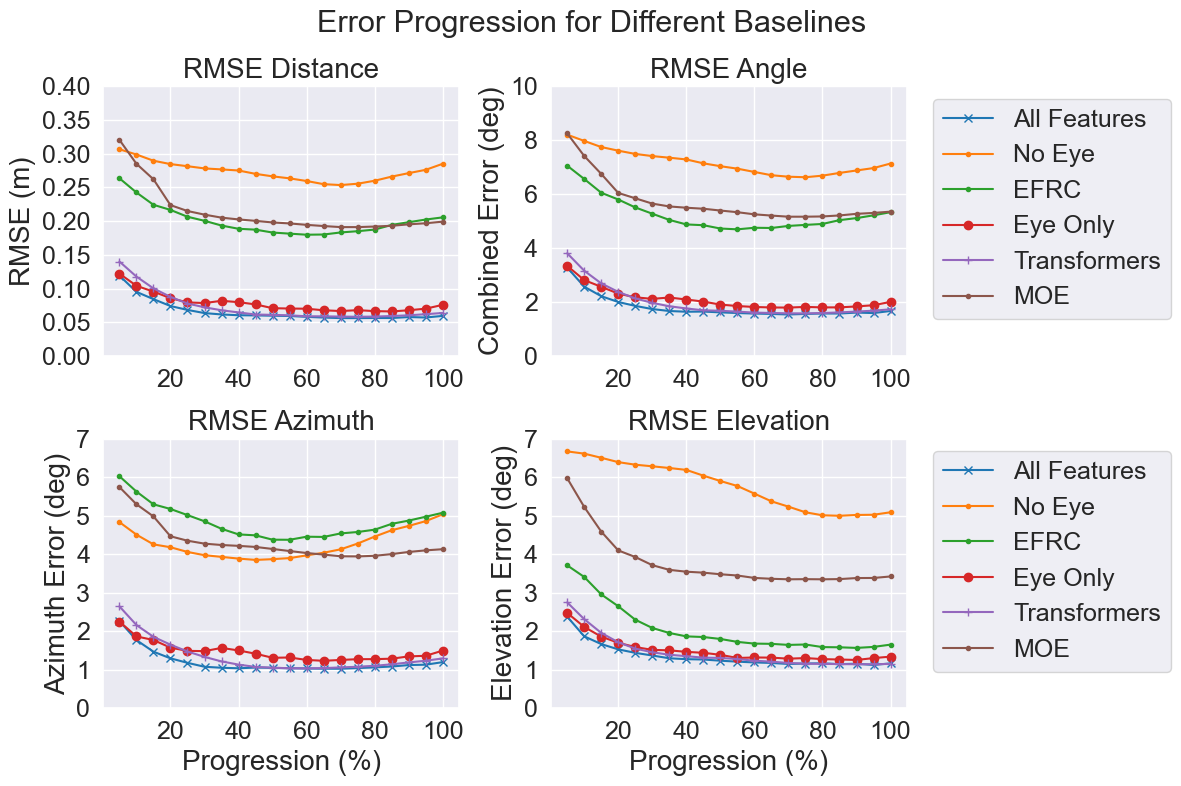

In [13]:
### plotting for m1 only ####
sns.set(style='darkgrid', palette='tab10')
fig = plt.figure(figsize=(12,8))
fig.suptitle("Error Progression for Different Baselines", fontsize="22")

ax1 = fig.add_subplot(221)
ax1.set_title('RMSE Distance', fontsize=20)
ax1.plot(x, y1.e_mse, label = "All Features", marker='x')
ax1.plot(x, y2.e_mse, label = "No Eye", marker='.')
ax1.plot(x, y3.e_mse, label = "EFRC", marker='.')
ax1.plot(x, y4.e_mse, label = "Eye Only", marker='o')
ax1.plot(x, y5.e_mse, label = "Transformers", marker='+')
ax1.plot(x, y6.e_mse, label = "MOE", marker='.')
# ax1.set_xlabel('Progression (%)', fontsize=20)
ax1.set_ylabel('RMSE (m)', fontsize=20)
ax1.set_ylim(0,0.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

ax2 = fig.add_subplot(222)
ax2.set_title('RMSE Angle', fontsize=20)
ax2.plot(x, y1.e_comb, label = "All Features", marker='x')
ax2.plot(x, y2.e_comb, label = "No Eye", marker='.')
ax2.plot(x, y3.e_comb, label = "EFRC", marker='.')
ax2.plot(x, y4.e_comb, label = "Eye Only", marker='o')
ax2.plot(x, y5.e_comb, label = "Transformers", marker='+')
ax2.plot(x, y6.e_comb, label = "MOE", marker='.')

# ax2.set_xlabel('Progression (%)', fontsize=20)
ax2.set_ylabel('Combined Error (deg)', fontsize=20)
ax2.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="18")

for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax2.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

ax3 = fig.add_subplot(223)
ax3.set_title('RMSE Azimuth', fontsize=20)
ax3.plot(x, y1.e_h, label = "All Features", marker='x')
ax3.plot(x, y2.e_h, label = "No Eye", marker='.')
ax3.plot(x, y3.e_h, label = "EFRC", marker='.')
ax3.plot(x, y4.e_h, label = "Eye Only", marker='o')
ax3.plot(x, y5.e_h, label = "Transformers", marker='+')
ax3.plot(x, y6.e_h, label = "MOE", marker='.')

ax3.set_xlabel('Progression (%)', fontsize=20)
ax3.set_ylabel('Azimuth Error (deg)', fontsize=20)
ax3.set_ylim(0,7)

for tick in ax3.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax3.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)


ax4 = fig.add_subplot(224)
ax4.set_title('RMSE Elevation', fontsize=20)
ax4.plot(x, y1.e_v, label = "All Features", marker='x')
ax4.plot(x, y2.e_v, label = "No Eye", marker='.')
ax4.plot(x, y3.e_v, label = "EFRC", marker='.')
ax4.plot(x, y4.e_v, label = "Eye Only", marker='o')
ax4.plot(x, y5.e_v, label = "Transformers", marker='+')
ax4.plot(x, y6.e_v, label = "MOE", marker='.')

ax4.set_xlabel('Progression (%)', fontsize=20)
ax4.set_ylabel('Elevation Error (deg)', fontsize=20)
ax4.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="18")
plt.tight_layout()

for tick in ax4.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax4.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)



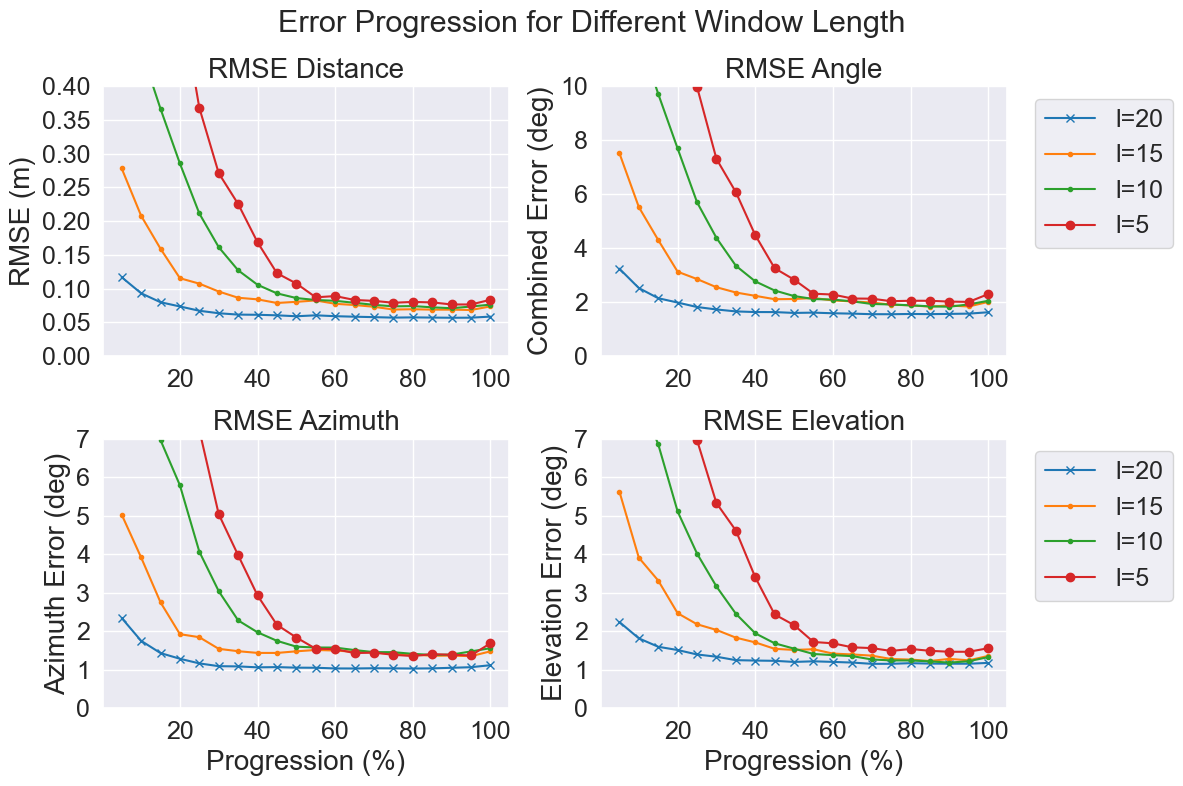

In [36]:
### plotting for m1 only ####
sns.set(style='darkgrid', palette='tab10')
fig = plt.figure(figsize=(12,8))
fig.suptitle("Error Progression for Different Window Length", fontsize="22")

ax1 = fig.add_subplot(221)
ax1.set_title('RMSE Distance', fontsize=20)
ax1.plot(x, y_20.e_mse, label = "l=20", marker='x')
ax1.plot(x, y_15.e_mse, label = "l=15", marker='.')
ax1.plot(x, y_10.e_mse, label = "l=10", marker='.')
ax1.plot(x, y_5.e_mse, label = "l=5", marker='o')
# ax1.set_xlabel('Progression (%)', fontsize=20)
ax1.set_ylabel('RMSE (m)', fontsize=20)
ax1.set_ylim(0,0.4)

for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

ax2 = fig.add_subplot(222)
ax2.set_title('RMSE Angle', fontsize=20)
ax2.plot(x, y_20.e_comb, label = "l=20", marker='x')
ax2.plot(x, y_15.e_comb, label = "l=15", marker='.')
ax2.plot(x, y_10.e_comb, label = "l=10", marker='.')
ax2.plot(x, y_5.e_comb, label = "l=5", marker='o')
# ax2.set_xlabel('Progression (%)', fontsize=20)
ax2.set_ylabel('Combined Error (deg)', fontsize=20)
ax2.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="18")

for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax2.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

ax3 = fig.add_subplot(223)
ax3.set_title('RMSE Azimuth', fontsize=20)
ax3.plot(x, y_20.e_h, label = "l=20", marker='x')
ax3.plot(x, y_15.e_h, label = "l=15", marker='.')
ax3.plot(x, y_10.e_h, label = "l=10", marker='.')
ax3.plot(x, y_5.e_h, label = "l=5", marker='o')
ax3.set_xlabel('Progression (%)', fontsize=20)
ax3.set_ylabel('Azimuth Error (deg)', fontsize=20)
ax3.set_ylim(0,7)

for tick in ax3.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax3.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)


ax4 = fig.add_subplot(224)
ax4.set_title('RMSE Elevation', fontsize=20)
ax4.plot(x, y_20.e_v, label = "l=20", marker='x')
ax4.plot(x, y_15.e_v, label = "l=15", marker='.')
ax4.plot(x, y_10.e_v, label = "l=10", marker='.')
ax4.plot(x, y_5.e_v, label = "l=5", marker='o')
ax4.set_xlabel('Progression (%)', fontsize=20)
ax4.set_ylabel('Elevation Error (deg)', fontsize=20)
ax4.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize="18")
plt.tight_layout()

for tick in ax4.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax4.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)


In [5]:
### plotting for all jackknife subjects ###

f18_names = [
    "m1-0622-jknf20-f18-s2-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s3-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s4-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s5-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s6-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s8-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s11-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s13-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s15-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s17-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s18-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s20-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s21-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-f18-s22-pc-testset-0623-1420.csv"
]
noeye_names = [
    "m1-0622-jknf20-noeye-s2-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s3-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s4-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s5-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s6-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s8-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s11-pc-testset-0623-1449.csv",
    "m1-0622-jknf20-noeye-s13-pc-testset-0623-1449.csv",
    "m1-0622-jknf20-noeye-s15-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s17-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s18-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s20-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s21-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-noeye-s22-pc-testset-0623-1422.csv"
]
noeyevec_names = [
    "m1-0622-jknf20-noeyevec-s2-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s3-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s4-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s5-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s6-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s8-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s11-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s13-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s15-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s17-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s18-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s20-pc-testset-0623-1800.csv",
    "m1-0622-jknf20-noeyevec-s21-pc-testset-0623-1801.csv",
    "m1-0622-jknf20-noeyevec-s22-pc-testset-0623-1801.csv",
]
justeye_names = [
    "m1-0622-jknf20-justeye-s2-pc-testset-0623-1420.csv",
    "m1-0622-jknf20-justeye-s3-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s4-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s5-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s6-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s8-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s11-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s13-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s15-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s17-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s18-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s20-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s21-pc-testset-0623-1421.csv",
    "m1-0622-jknf20-justeye-s22-pc-testset-0623-1421.csv"
]    
df_f18_list = []
df_noeye_list = []
df_noeyevec_list = []
df_justeye_list = []
y_f18_list = []
y_noeye_list = []
y_noeyevec_list = []
y_justeye_list = []

subjects = [2,3,4,5,6, 8,11,13,15,17, 18,20,21,22]
common_path = "data/model1_jackknife/"
for i, subject in enumerate(subjects):
    path_f18 = common_path + f18_names[i] 
    path_noeye = common_path + noeye_names[i]
    path_noeyevec = common_path + noeyevec_names[i]
    path_justeye = common_path + justeye_names[i]
    
    df_f18 = pd.read_csv(path_f18 ,na_values=" NaN").dropna(how='all', axis=1)
    df_noeye = pd.read_csv(path_noeye ,na_values=" NaN").dropna(how='all', axis=1)
    df_noeyevec = pd.read_csv(path_noeyevec ,na_values=" NaN").dropna(how='all', axis=1)
    df_justeye = pd.read_csv(path_justeye ,na_values=" NaN").dropna(how='all', axis=1)
    
    df_f18_list.append(df_f18)
    df_noeye_list.append(df_noeye)
    df_noeyevec_list.append(df_noeyevec)
    df_justeye_list.append(df_justeye)
    
    y_f18_list.append(draw_errors_all(df_f18, "df_f18"))
    y_noeye_list.append(draw_errors_all(df_noeye, "df_noeye"))
    y_noeyevec_list.append(draw_errors_all(df_noeyevec, "df_noeyevec"))
    y_justeye_list.append(draw_errors_all(df_justeye, "df_justeye"))



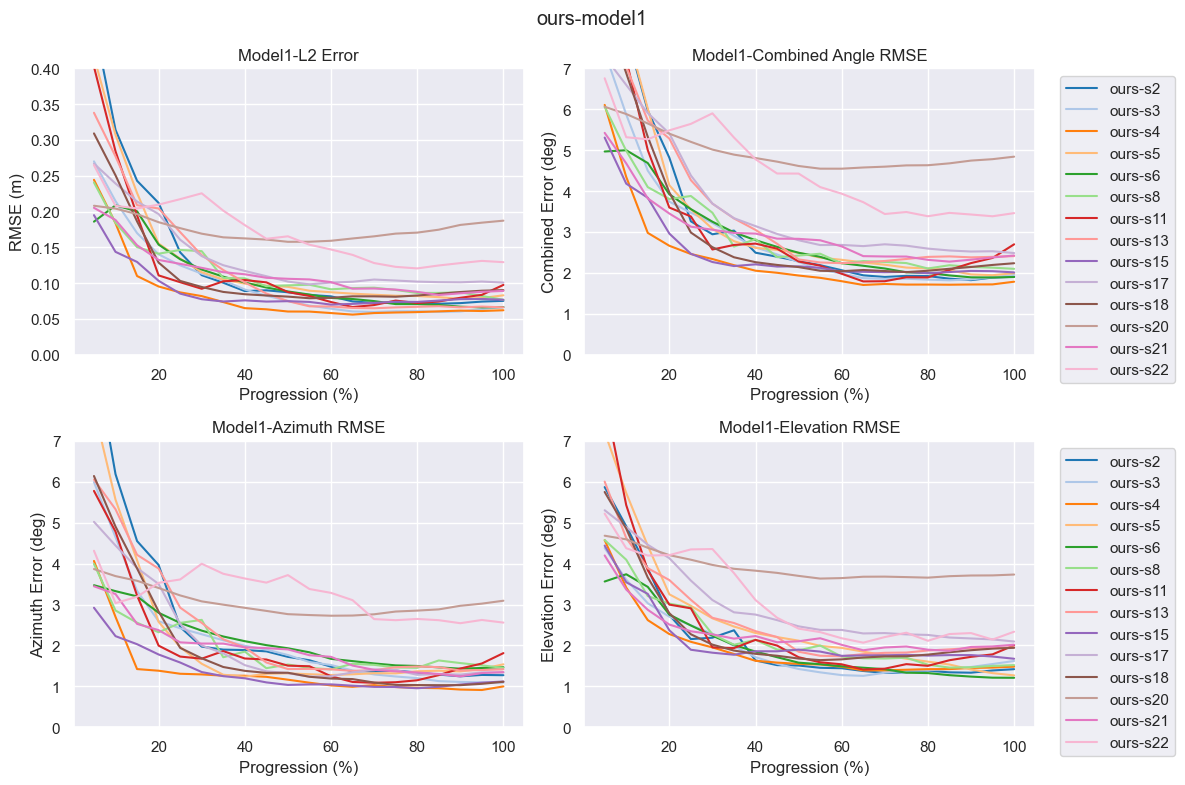

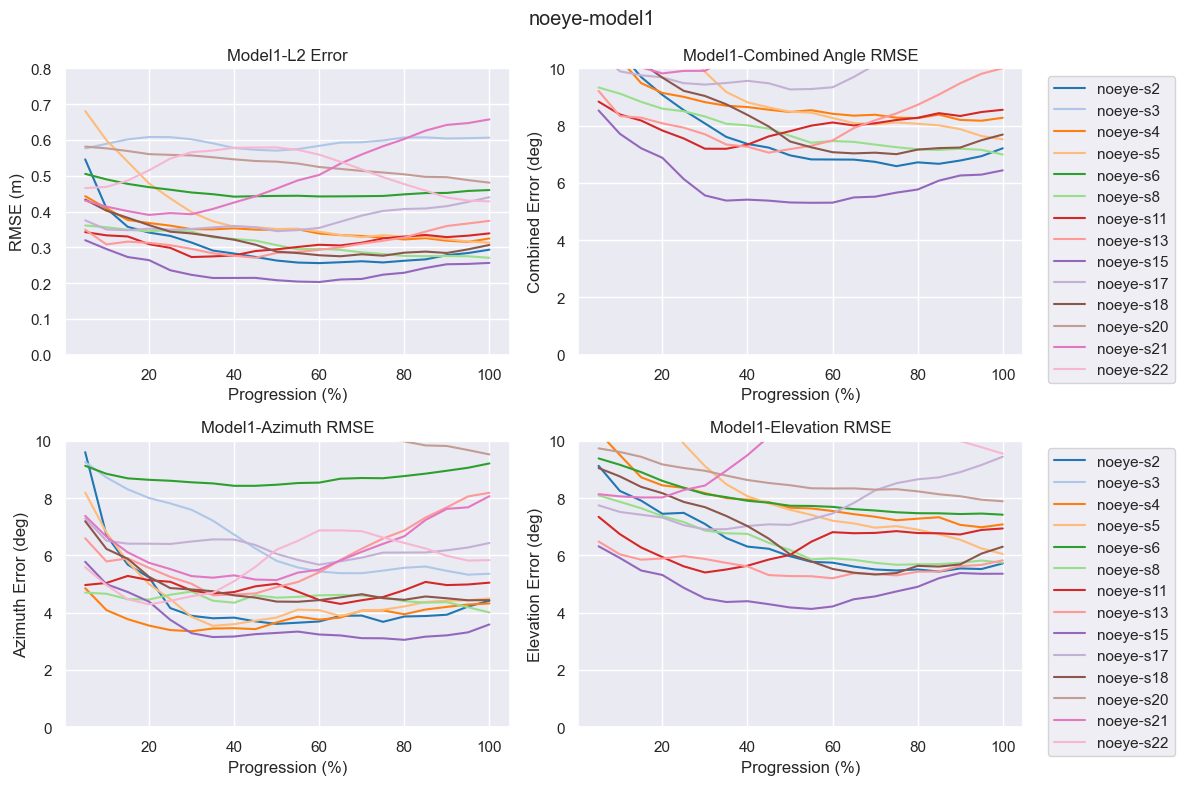

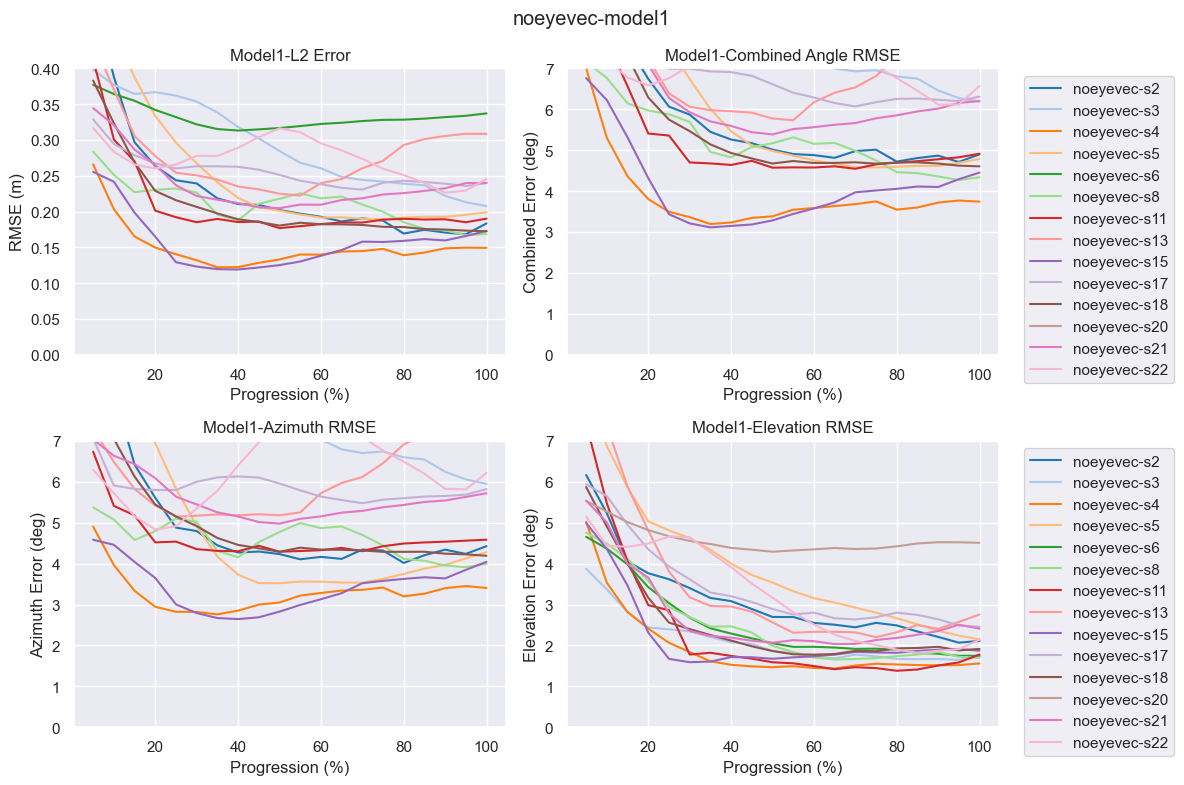

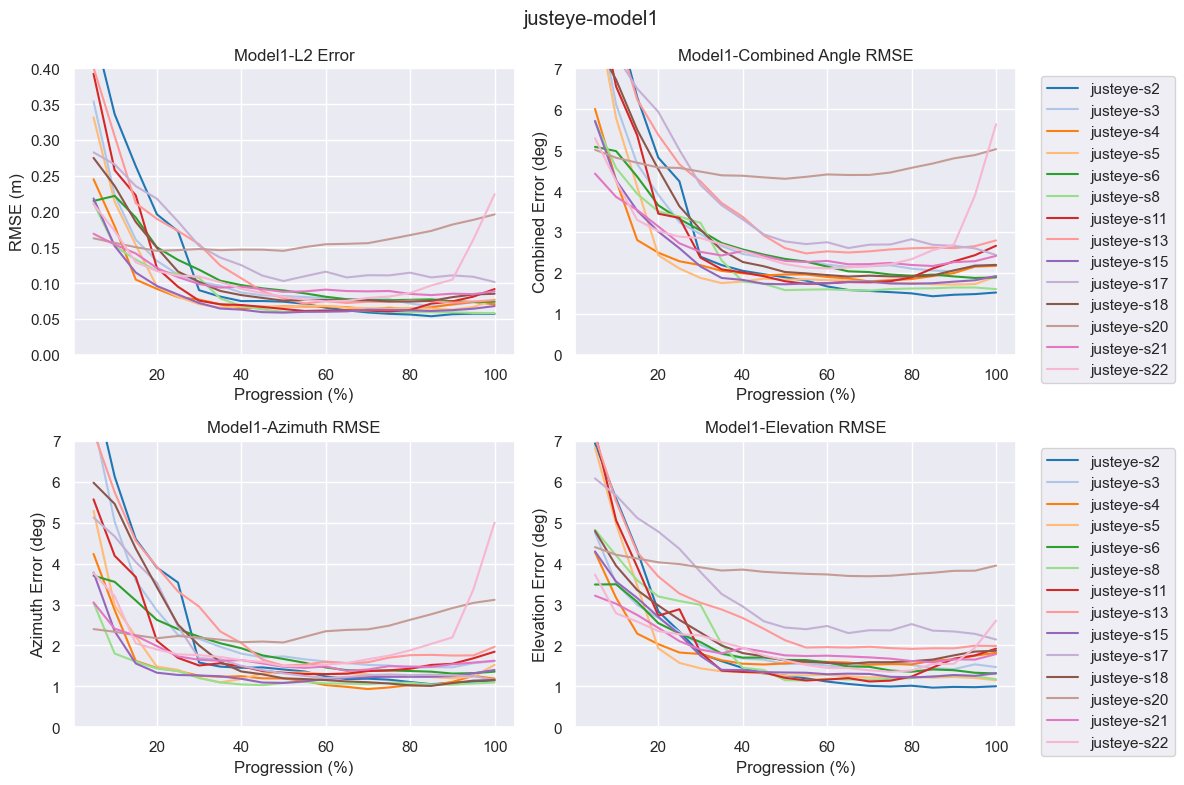

In [6]:
### plot jackknife subjects


x = np.arange(5, 105, 5)
x =pd.Series(x, name='x') 
subject_names = ["s2","s3","s4","s5","s6", "s8","s11","s13","s15","s17", "s18","s20","s21","s22"]

#===================================================================
sns.set(style='darkgrid', palette='tab20')
fig = plt.figure(figsize=(12,8))
y_list = y_f18_list
legend_pretext = "ours-"
fig.suptitle(legend_pretext+"model1")
ax1 = fig.add_subplot(221)
ax1.set_title('Model1-L2 Error')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax1.plot(x, y.e_mse, label=legend_pretext+subject) 
ax1.set_xlabel('Progression (%)')
ax1.set_ylabel('RMSE (m)')
ax1.set_ylim(0,0.4)

ax2 = fig.add_subplot(222)
ax2.set_title('Model1-Combined Angle RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax2.plot(x, y.e_comb, label=legend_pretext+subject) 
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Combined Error (deg)')
ax2.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

ax3 = fig.add_subplot(223)
ax3.set_title('Model1-Azimuth RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax3.plot(x, y.e_h, label=legend_pretext+subject) 
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Azimuth Error (deg)')
ax3.set_ylim(0,7)


ax4 = fig.add_subplot(224)
ax4.set_title('Model1-Elevation RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax4.plot(x, y.e_v, label=legend_pretext+subject) 
ax4.set_xlabel('Progression (%)')
ax4.set_ylabel('Elevation Error (deg)')
ax4.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
#===================================================================
sns.set(style='darkgrid', palette='tab20')
fig = plt.figure(figsize=(12,8))
y_list = y_noeye_list
legend_pretext = "noeye-"
fig.suptitle(legend_pretext+"model1")
ax1 = fig.add_subplot(221)
ax1.set_title('Model1-L2 Error')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax1.plot(x, y.e_mse, label=legend_pretext+subject) 
ax1.set_xlabel('Progression (%)')
ax1.set_ylabel('RMSE (m)')
ax1.set_ylim(0,0.8)

ax2 = fig.add_subplot(222)
ax2.set_title('Model1-Combined Angle RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax2.plot(x, y.e_comb, label=legend_pretext+subject) 
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Combined Error (deg)')
ax2.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

ax3 = fig.add_subplot(223)
ax3.set_title('Model1-Azimuth RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax3.plot(x, y.e_h, label=legend_pretext+subject) 
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Azimuth Error (deg)')
ax3.set_ylim(0,10)


ax4 = fig.add_subplot(224)
ax4.set_title('Model1-Elevation RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax4.plot(x, y.e_v, label=legend_pretext+subject) 
ax4.set_xlabel('Progression (%)')
ax4.set_ylabel('Elevation Error (deg)')
ax4.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
#===================================================================
sns.set(style='darkgrid', palette='tab20')
fig = plt.figure(figsize=(12,8))
y_list = y_noeyevec_list
legend_pretext = "noeyevec-"
fig.suptitle(legend_pretext+"model1")
ax1 = fig.add_subplot(221)
ax1.set_title('Model1-L2 Error')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax1.plot(x, y.e_mse, label=legend_pretext+subject) 
ax1.set_xlabel('Progression (%)')
ax1.set_ylabel('RMSE (m)')
ax1.set_ylim(0,0.4)

ax2 = fig.add_subplot(222)
ax2.set_title('Model1-Combined Angle RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax2.plot(x, y.e_comb, label=legend_pretext+subject) 
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Combined Error (deg)')
ax2.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

ax3 = fig.add_subplot(223)
ax3.set_title('Model1-Azimuth RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax3.plot(x, y.e_h, label=legend_pretext+subject) 
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Azimuth Error (deg)')
ax3.set_ylim(0,7)


ax4 = fig.add_subplot(224)
ax4.set_title('Model1-Elevation RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax4.plot(x, y.e_v, label=legend_pretext+subject) 
ax4.set_xlabel('Progression (%)')
ax4.set_ylabel('Elevation Error (deg)')
ax4.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
#===================================================================
sns.set(style='darkgrid', palette='tab20')
fig = plt.figure(figsize=(12,8))
y_list = y_justeye_list
legend_pretext = "justeye-"
fig.suptitle(legend_pretext+"model1")
ax1 = fig.add_subplot(221)
ax1.set_title('Model1-L2 Error')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax1.plot(x, y.e_mse, label=legend_pretext+subject) 
ax1.set_xlabel('Progression (%)')
ax1.set_ylabel('RMSE (m)')
ax1.set_ylim(0,0.4)

ax2 = fig.add_subplot(222)
ax2.set_title('Model1-Combined Angle RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax2.plot(x, y.e_comb, label=legend_pretext+subject) 
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Combined Error (deg)')
ax2.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

ax3 = fig.add_subplot(223)
ax3.set_title('Model1-Azimuth RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax3.plot(x, y.e_h, label=legend_pretext+subject) 
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Azimuth Error (deg)')
ax3.set_ylim(0,7)


ax4 = fig.add_subplot(224)
ax4.set_title('Model1-Elevation RMSE')
for i, (y, subject) in enumerate(zip(y_list, subject_names)):
    ax4.plot(x, y.e_v, label=legend_pretext+subject) 
ax4.set_xlabel('Progression (%)')
ax4.set_ylabel('Elevation Error (deg)')
ax4.set_ylim(0,7)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()






In [7]:
# https://coding-grandpa.tistory.com/entry/PythonSeaborn-Seaborn-%ED%95%84%EC%88%98-%EA%B7%B8%EB%9E%98%ED%94%84-%EC%A0%95%EB%A6%AC-Line-plot%EA%B3%BC-Scatter-plot
# f18, noeye, noeyevec, justeye
df1 = pd.read_csv("data/conf_model1/conf_m1-0707abs-f18-pc-testset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)
df2 = pd.read_csv("data/conf_model1/conf_m1-0707abs-noeye-pc-testset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)
df3 = pd.read_csv("data/conf_model1/conf_m1-0707abs-noeyevec-pc-testset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)
df4 = pd.read_csv("data/conf_model1/conf_m1-0707abs-justeye-pc-testset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)

df1_train = pd.read_csv("data/conf_model1/conf_m1-0707abs-f18-pc-trainset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)
df2_train = pd.read_csv("data/conf_model1/conf_m1-0707abs-noeye-pc-trainset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)
df3_train = pd.read_csv("data/conf_model1/conf_m1-0707abs-noeyevec-pc-trainset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)
df4_train = pd.read_csv("data/conf_model1/conf_m1-0707abs-justeye-pc-trainset-0717-1458.csv",na_values=" NaN").dropna(how='all', axis=1)


In [8]:
def draw_conf_errors_all(df, input_result_name=None):
    new_frames = 20
    # one temporal plot for whole dataset
    l_sub_idx = df.sub_idx.unique()

    df['sub_group'] = df.groupby(['sub_idx']).ngroup() # 4 for evaluation
    # df = df.sort_values(by=['sub_idx', 'file_idx','win_idx']) #only files and subject
    l_sub_group = df.sub_group.unique()
    
    df['resample_group'] = df.groupby(['sub_idx', 'file_idx']).ngroup()          

    l_resample_group = df.resample_group.unique()
    
    # sort all frames in each group and resample, and then append each 10-frame-list
    l_output = []
    l_df_resample = []
    for i, regrp_idx in enumerate(l_resample_group):
        df_resample = df.loc[df.resample_group==regrp_idx]
        df_resample = resample_df(df_resample, new_frames)
        df_resample = df_resample.reset_index(drop=True) #essential
        l_df_resample.append(df_resample)
        
    # print(df_resample)
    # now mean all respective index frame for all resample sequence
    df_resample = pd.concat(l_df_resample)
    df_resample_he = df_resample.groupby(df_resample.index)["h_e"].apply(rms)
    df_resample_ve = df_resample.groupby(df_resample.index)["v_e"].apply(rms)
    df_resample_eh = df_resample.groupby(df_resample.index)["e_h"].apply(rms)
    df_resample_ev = df_resample.groupby(df_resample.index)["e_v"].apply(rms)
    out = pd.DataFrame([df_resample_eh, df_resample_ev, df_resample_he, df_resample_ve]).transpose()
    out["p_comb"] = combined_angles(df_resample_he, df_resample_ve)
    out["e_comb"] = combined_angles(df_resample_eh, df_resample_ev)
    # print(out)
    
    return out

In [9]:

y1=draw_conf_errors_all(df1, "f18")
y2=draw_conf_errors_all(df2, "noeye")
y3=draw_conf_errors_all(df3, "noeyevec")
y4=draw_conf_errors_all(df4, "justeye")

y1_train=draw_conf_errors_all(df1_train, "f18")
y2_train=draw_conf_errors_all(df2_train, "noeye")
y3_train=draw_conf_errors_all(df3_train, "noeyevec")
y4_train=draw_conf_errors_all(df4_train, "justeye")

x = np.arange(5, 105, 5)
x =pd.Series(x, name='x') 

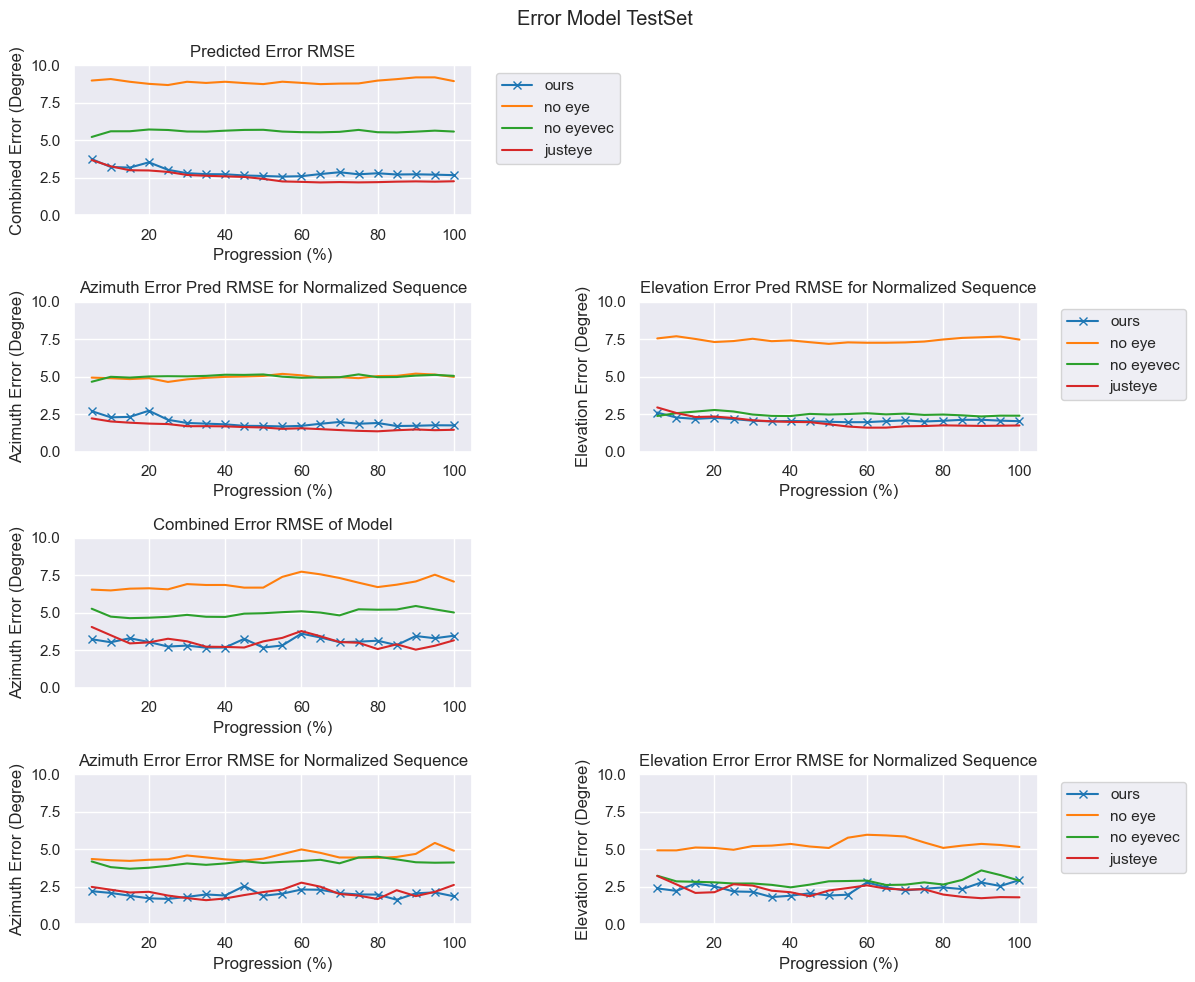

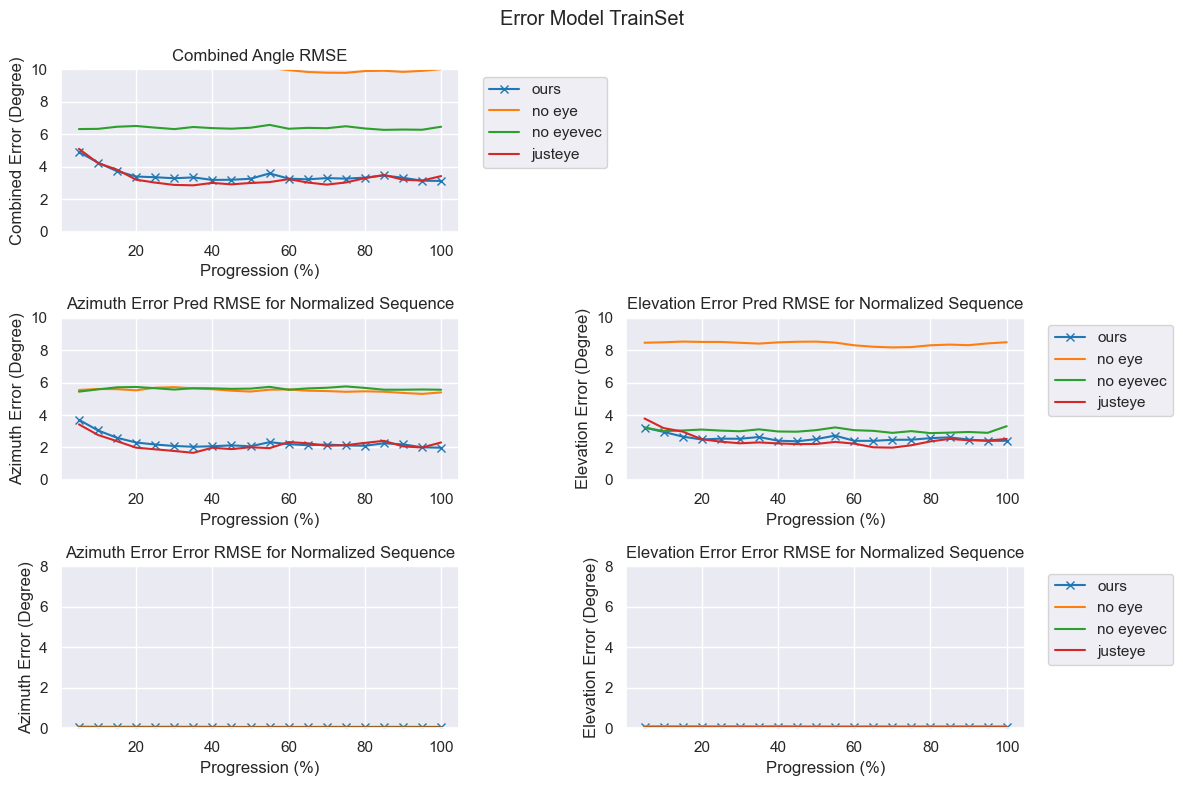

In [10]:
sns.set(style='darkgrid', palette='tab10')
fig = plt.figure(figsize=(12,10))
fig.suptitle('Error Model TestSet')
title = 'Predicted Error RMSE for Normalized Sequence'
ax1 = fig.add_subplot(421)
ax1.set_title('Predicted Error RMSE')
ax1.plot(x, y1.p_comb, label = "ours",marker="x")
ax1.plot(x, y2.p_comb, label = "no eye")
ax1.plot(x, y3.p_comb, label = "no eyevec")
ax1.plot(x, y4.p_comb, label = "justeye")
ax1.set_xlabel('Progression (%)')
ax1.set_ylabel('Combined Error (Degree)')
ax1.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


title = 'Azimuth Error Pred RMSE for Normalized Sequence'
ax2 = fig.add_subplot(423)
ax2.set_title(title)
ax2.plot(x, y1.h_e, label = "ours",marker="x")
ax2.plot(x, y2.h_e, label = "no eye")
ax2.plot(x, y3.h_e, label = "no eyevec")
ax2.plot(x, y4.h_e, label = "justeye")
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Azimuth Error (Degree)')
ax2.set_ylim(0,10)

title = 'Elevation Error Pred RMSE for Normalized Sequence'
ax3 = fig.add_subplot(424)
ax3.set_title(title)
ax3.plot(x, y1.v_e, label = "ours",marker="x")
ax3.plot(x, y2.v_e, label = "no eye")
ax3.plot(x, y3.v_e, label = "no eyevec")
ax3.plot(x, y4.v_e, label = "justeye")
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Elevation Error (Degree)')
ax3.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


title = 'Combined Error RMSE of Model'
ax4 = fig.add_subplot(425)
ax4.set_title(title)
ax4.plot(x, y1.e_comb, label = "ours",marker="x")
ax4.plot(x, y2.e_comb, label = "no eye")
ax4.plot(x, y3.e_comb, label = "no eyevec")
ax4.plot(x, y4.e_comb, label = "justeye")
ax4.set_xlabel('Progression (%)')
ax4.set_ylabel('Azimuth Error (Degree)')
ax4.set_ylim(0,10)


title = 'Azimuth Error Error RMSE for Normalized Sequence'
ax5 = fig.add_subplot(427)
ax5.set_title(title)
ax5.plot(x, y1.e_h, label = "ours",marker="x")
ax5.plot(x, y2.e_h, label = "no eye")
ax5.plot(x, y3.e_h, label = "no eyevec")
ax5.plot(x, y4.e_h, label = "justeye")
ax5.set_xlabel('Progression (%)')
ax5.set_ylabel('Azimuth Error (Degree)')
ax5.set_ylim(0,10)


title = 'Elevation Error Error RMSE for Normalized Sequence'
ax6 = fig.add_subplot(428)
ax6.set_title(title)
ax6.plot(x, y1.e_v, label = "ours",marker="x")
ax6.plot(x, y2.e_v, label = "no eye")
ax6.plot(x, y3.e_v, label = "no eyevec")
ax6.plot(x, y4.e_v, label = "justeye")
ax6.set_xlabel('Progression (%)')
ax6.set_ylabel('Elevation Error (Degree)')
ax6.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()




#----------TRAINSET----------------------------------------
fig = plt.figure(figsize=(12,8))
fig.suptitle('Error Model TrainSet')
sns.set(style='darkgrid', palette='tab10')

ax1 = fig.add_subplot(321)
ax1.set_title('Combined Angle RMSE')
ax1.plot(x, y1_train.p_comb, label = "ours",marker="x")
ax1.plot(x, y2_train.p_comb, label = "no eye")
ax1.plot(x, y3_train.p_comb, label = "no eyevec")
ax1.plot(x, y4_train.p_comb, label = "justeye")
ax1.set_xlabel('Progression (%)')
ax1.set_ylabel('Combined Error (Degree)')
ax1.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


title = 'Azimuth Error Pred RMSE for Normalized Sequence'
ax2 = fig.add_subplot(323)
ax2.set_title(title)
ax2.plot(x, y1_train.h_e, label = "ours",marker="x")
ax2.plot(x, y2_train.h_e, label = "no eye")
ax2.plot(x, y3_train.h_e, label = "no eyevec")
ax2.plot(x, y4_train.h_e, label = "justeye")
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Azimuth Error (Degree)')
ax2.set_ylim(0,10)

title = 'Elevation Error Pred RMSE for Normalized Sequence'
ax3 = fig.add_subplot(324)
ax3.set_title(title)
ax3.plot(x, y1_train.v_e, label = "ours",marker="x")
ax3.plot(x, y2_train.v_e, label = "no eye")
ax3.plot(x, y3_train.v_e, label = "no eyevec")
ax3.plot(x, y4_train.v_e, label = "justeye")
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Elevation Error (Degree)')
ax3.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


title = 'Azimuth Error Error RMSE for Normalized Sequence'
ax4 = fig.add_subplot(325)
ax4.set_title(title)
ax4.plot(x, y1_train.e_h, label = "ours",marker="x")
ax4.plot(x, y2_train.e_h, label = "no eye")
ax4.plot(x, y3_train.e_h, label = "no eyevec")
ax4.plot(x, y4_train.e_h, label = "justeye")
ax4.set_xlabel('Progression (%)')
ax4.set_ylabel('Azimuth Error (Degree)')
ax4.set_ylim(0,8)


title = 'Elevation Error Error RMSE for Normalized Sequence'
ax5 = fig.add_subplot(326)
ax5.set_title(title)
ax5.plot(x, y1_train.e_v, label = "ours",marker="x")
ax5.plot(x, y2_train.e_v, label = "no eye")
ax5.plot(x, y3_train.e_v, label = "no eyevec")
ax5.plot(x, y4_train.e_v, label = "justeye")
ax5.set_xlabel('Progression (%)')
ax5.set_ylabel('Elevation Error (Degree)')
ax5.set_ylim(0,8)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()



In [11]:
def draw_conf_errors_all(df, input_result_name=None):
    new_frames = 20
    # one temporal plot for whole dataset
    l_sub_idx = df.sub_idx.unique()

    df['sub_group'] = df.groupby(['sub_idx']).ngroup() # 4 for evaluation
    df = df.sort_values(by=['file_idx','sub_idx','win_idx']) #only files and subject
    l_sub_group = df.sub_group.unique()
    
    df['resample_group'] = df.groupby(['sub_idx', 'file_idx']).ngroup()          

    l_resample_group = df.resample_group.unique()
    
    # sort all frames in each group and resample, and then append each 10-frame-list
    l_output = []
    l_df_resample = []
    for i, regrp_idx in enumerate(l_resample_group):
        df_resample = df.loc[df.resample_group==regrp_idx]
        df_resample = resample_df(df_resample, new_frames)
        df_resample = df_resample.reset_index(drop=True) #essential
        l_df_resample.append(df_resample)
        
    # print(df_resample)
    # now mean all respective index frame for all resample sequence
    df_resample = pd.concat(l_df_resample)
    df_resample_he = df_resample.groupby(df_resample.index)["h_e"].apply(rms)
    df_resample_ve = df_resample.groupby(df_resample.index)["v_e"].apply(rms)
    df_resample_eh = df_resample.groupby(df_resample.index)["e_h"].apply(rms)
    df_resample_ev = df_resample.groupby(df_resample.index)["e_v"].apply(rms)
    out = pd.DataFrame([df_resample_eh, df_resample_ev, df_resample_he, df_resample_ve]).transpose()
    out["e_comb"] = combined_angles(df_resample_eh, df_resample_ev)
    out["p_comb"] = combined_angles(df_resample_he, df_resample_ve)

    # print(out)
    
    return out

In [12]:
# df_conf_f18 = pd.read_csv("data/model1_conf_model/m1-0627-f18-pc-conf-testset-0628-1539.csv",na_values=" NaN")
# df_conf_noeye = pd.read_csv("data/model1_conf_model/m1-0627-noeye-pc-conf-testset-0628-1539.csv",na_values=" NaN")
# df_conf_noeyevec = pd.read_csv("data/model1_conf_model/m1-0627-noeyevec-pc-conf-testset-0628-1539.csv",na_values=" NaN")
# df_conf_justeye = pd.read_csv("data/model1_conf_model/m1-0627-justeye-pc-conf-testset-0628-1539.csv",na_values=" NaN")

# df_conf_f18 = pd.read_csv("data/model1_conf_model/m1-0627-f18-pc-conf-testset-0717-1457.csv",na_values=" NaN")
# df_conf_noeye = pd.read_csv("data/model1_conf_model/m1-0627-noeye-pc-conf-testset-0717-1457.csv",na_values=" NaN")
# df_conf_noeyevec = pd.read_csv("data/model1_conf_model/m1-0627-noeyevec-pc-conf-testset-0717-1457.csv",na_values=" NaN")
# df_conf_justeye = pd.read_csv("data/model1_conf_model/m1-0627-justeye-pc-conf-testset-0717-1457.csv",na_values=" NaN")
# df_conf_f18 = pd.read_csv("data/model1_conf_model/m1-0627-f18-pc-conf-testset-0717-1458.csv",na_values=" NaN")
# df_conf_noeye = pd.read_csv("data/model1_conf_model/m1-0627-noeye-pc-conf-testset-0717-1458.csv",na_values=" NaN")
# df_conf_noeyevec = pd.read_csv("data/model1_conf_model/m1-0627-noeyevec-pc-conf-testset-0717-1458.csv",na_values=" NaN")
# df_conf_justeye = pd.read_csv("data/model1_conf_model/m1-0627-justeye-pc-conf-testset-0717-1458.csv",na_values=" NaN")
# df_conf_f18 = pd.read_csv("data/model1_conf_model/m1-0627-f18-pc-conf-testset-0717-1459.csv",na_values=" NaN")
# df_conf_noeye = pd.read_csv("data/model1_conf_model/m1-0627-noeye-pc-conf-testset-0717-1459.csv",na_values=" NaN")
# df_conf_noeyevec = pd.read_csv("data/model1_conf_model/m1-0627-noeyevec-pc-conf-testset-0717-1459.csv",na_values=" NaN")
# df_conf_justeye = pd.read_csv("data/model1_conf_model/m1-0627-justeye-pc-conf-testset-0717-1459.csv",na_values=" NaN")
df_conf_f18 = pd.read_csv("data/model1_conf_model/m1-0627-f18-pc-conf-testset-0717-1609.csv",na_values=" NaN")
df_conf_noeye = pd.read_csv("data/model1_conf_model/m1-0627-noeye-pc-conf-testset-0717-1609.csv",na_values=" NaN")
df_conf_noeyevec = pd.read_csv("data/model1_conf_model/m1-0627-noeyevec-pc-conf-testset-0717-1609.csv",na_values=" NaN")
df_conf_justeye = pd.read_csv("data/model1_conf_model/m1-0627-justeye-pc-conf-testset-0717-1609.csv",na_values=" NaN")

# df_conf_f18_s2 = pd.read_csv("data/model1_conf_model/m1-0622-jknf20-f18-s2-pc-conf-testset-0627-1028.csv",na_values=" NaN")
# df_conf_f18_s3 = pd.read_csv("data/model1_conf_model/m1-0622-jknf20-f18-s3-pc-conf-testset-0627-1028.csv",na_values=" NaN")

df_conf_f18 = df_conf_f18.dropna(how='all', axis=1)
df_conf_noeye = df_conf_noeye.dropna(how='all', axis=1)
df_conf_noeyevec = df_conf_noeyevec.dropna(how='all', axis=1)
df_conf_justeye = df_conf_justeye.dropna(how='all', axis=1)
# df_conf_f18_s2 = df_conf_f18_s2.dropna(how='all', axis=1)
# df_conf_f18_s3 = df_conf_f18_s3.dropna(how='all', axis=1)

y_conf_f18=draw_conf_errors_all(df_conf_f18, "f18")
y_conf_noeye=draw_conf_errors_all(df_conf_noeye, "noeye")
y_conf_noeyevec=draw_conf_errors_all(df_conf_noeyevec, "noeyevec")
y_conf_justeye=draw_conf_errors_all(df_conf_justeye, "justeye")
# y_conf_f18_s2 = draw_conf_errors_all(df_conf_f18_s2, "f18")
# y_conf_f18_s3 = draw_conf_errors_all(df_conf_f18_s3, "f18")

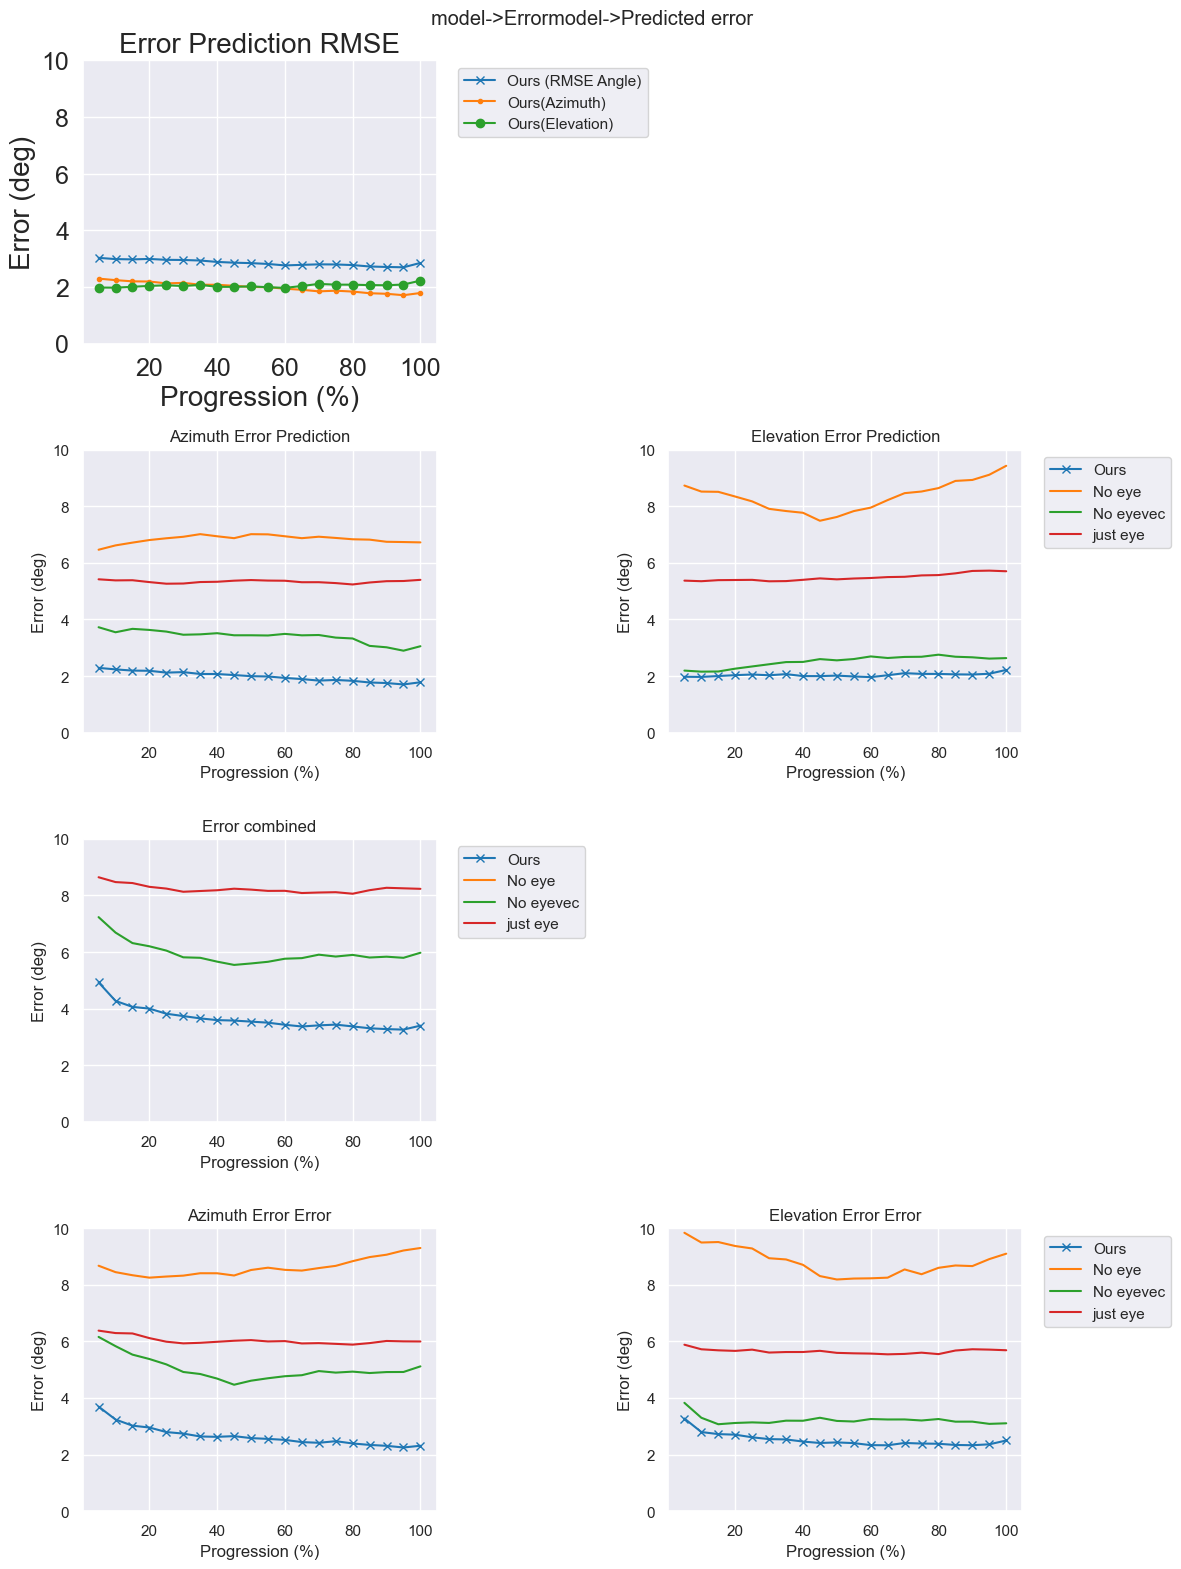

In [13]:
# print(y1, y2, y3, y4)

x = np.arange(5, 105, 5)
x =pd.Series(x, name='x') 


# sns.set(style='darkgrid', palette='tab10')
# fig = plt.figure(figsize=(12,12))
# fig.suptitle("model->Errormodel->Predicted error")
# ax1 = fig.add_subplot(421)
# ax1.set_title("Error Prediction RMSE")
# ax1.plot(x, y_conf_f18.p_comb, label = "Ours", marker="x")
# ax1.plot(x, y_conf_noeye.p_comb, label ="No eye", marker='.')
# # ax1.plot(x, y_conf_noeyevec.p_comb, label = "No eyevec")
# ax1.plot(x, y_conf_justeye.p_comb, label = "just eye", marker='o')
# ax1.set_xlabel('Progression (%)')
# ax1.set_ylabel('Error (deg)')
# ax1.set_ylim(0,10)
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

#------for poster
sns.set(style='darkgrid', palette='tab10')
# fig = plt.figure(figsize=(12,12))
fig = plt.figure(figsize=(12,16))
fig.suptitle("model->Errormodel->Predicted error")
ax1 = fig.add_subplot(421)
ax1.set_title("Error Prediction RMSE",fontsize=20)
ax1.plot(x, y_conf_f18.p_comb, label = "Ours (RMSE Angle)", marker="x")
ax1.plot(x, y_conf_f18.h_e, label ="Ours(Azimuth)", marker='.')
# ax1.plot(x, y_conf_noeyevec.p_comb, label = "No eyevec")
ax1.plot(x, y_conf_f18.v_e, label = "Ours(Elevation)", marker='o')
ax1.set_xlabel('Progression (%)',fontsize=20)
ax1.set_ylabel('Error (deg)',fontsize=20)
ax1.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)


ax2 = fig.add_subplot(423)
ax2.set_title("Azimuth Error Prediction")
ax2.plot(x, y_conf_f18.h_e, label = "Ours", marker="x")
ax2.plot(x, y_conf_noeye.h_e, label = "No eye")
ax2.plot(x, y_conf_noeyevec.h_e, label = "No eyevec")
ax2.plot(x, y_conf_justeye.h_e, label = "just eye")
ax2.set_xlabel('Progression (%)')
ax2.set_ylabel('Error (deg)')
ax2.set_ylim(0,10)

ax3 = fig.add_subplot(424)
ax3.set_title("Elevation Error Prediction")
ax3.plot(x, y_conf_f18.v_e, label = "Ours", marker="x")
ax3.plot(x, y_conf_noeye.v_e, label = "No eye")
ax3.plot(x, y_conf_noeyevec.v_e, label = "No eyevec")
ax3.plot(x, y_conf_justeye.v_e, label = "just eye")
ax3.set_xlabel('Progression (%)')
ax3.set_ylabel('Error (deg)')
ax3.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


ax5 = fig.add_subplot(425)
ax5.set_title("Error combined")
ax5.plot(x, y_conf_f18.e_comb, label = "Ours", marker="x")
ax5.plot(x, y_conf_noeye.e_comb, label ="No eye")
ax5.plot(x, y_conf_noeyevec.e_comb, label = "No eyevec")
ax5.plot(x, y_conf_justeye.e_comb, label = "just eye")
ax5.set_xlabel('Progression (%)')
ax5.set_ylabel('Error (deg)')
ax5.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


ax6 = fig.add_subplot(427)
ax6.set_title("Azimuth Error Error")
ax6.plot(x, y_conf_f18.e_h, label = "Ours", marker="x")
ax6.plot(x, y_conf_noeye.e_h, label = "No eye")
ax6.plot(x, y_conf_noeyevec.e_h, label = "No eyevec")
ax6.plot(x, y_conf_justeye.e_h, label = "just eye")
ax6.set_xlabel('Progression (%)')
ax6.set_ylabel('Error (deg)')
ax6.set_ylim(0,10)



ax7 = fig.add_subplot(428)
ax7.set_title("Elevation Error Error")
ax7.plot(x, y_conf_f18.e_v, label = "Ours", marker="x")
ax7.plot(x, y_conf_noeye.e_v, label = "No eye")
ax7.plot(x, y_conf_noeyevec.e_v, label = "No eyevec")
ax7.plot(x, y_conf_justeye.e_v, label = "just eye")
ax7.set_xlabel('Progression (%)')
ax7.set_ylabel('Error (deg)')
ax7.set_ylim(0,10)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()



# ax5 = fig.add_subplot(325)
# ax5.set_title("S2 (Error Prediction Model)")
# ax5.plot(x, y_conf_f18_s2.e_comb, label = "Ours", marker="x")
# ax5.plot(x, y_conf_f18_s2.h_pred_error, label = "Azimuth Error RMSE (s2)")
# ax5.plot(x, y_conf_f18_s2.v_pred_error, label = "Elevation Error RMSE (s2)")
# ax5.plot(x, y_conf_f18_s2.v_pred_error, label = "Elevation Error RMSE (s2)")
# ax5.set_xlabel('Progression (%)')
# ax5.set_ylim(0,10)
# ax5.set_ylabel('Error (deg)')

# ax6 = fig.add_subplot(326)
# ax6.set_title("S3 (Error Prediction Model)")
# ax6.plot(x, y_conf_f18_s3.e_comb, label = "Ours", marker="x")
# ax6.plot(x, y_conf_f18_s3.h_pred_error, label = "Azimuth Error RMSE (s3)")
# ax6.plot(x, y_conf_f18_s3.v_pred_error, label = "Elevation Error RMSE (s3)")
# ax6.plot(x, y_conf_f18_s3.v_pred_error, label = "Elevation Error RMSE (s3)")
# ax6.set_xlabel('Progression (%)')
# ax6.set_ylabel('Error (deg)')
# ax6.set_ylim(0,10)
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.tight_layout()